<a href="https://colab.research.google.com/github/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis/blob/main/code/practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
from PIL import Image
from skimage.measure import label
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

import torchvision
import torch
from torch.utils.data import DataLoader

In [2]:
pwd

'/content'

In [3]:
from google.colab import drive
drive.mount("/content/gdrive/")

path_github = "IMAS_MachineLearning_Workshop-Image_Analysis"
if not os.path.isdir(path_github):
    !git clone https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis.git

%cd IMAS_MachineLearning_Workshop-Image_Analysis/code/

!git fetch
!git pull origin main

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/IMAS_MachineLearning_Workshop-Image_Analysis/code
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10 (delta 5), reused 6 (delta 3), pack-reused 0
Unpacking objects: 100% (10/10), done.
From https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis
   f0ded01..bc95f77  main       -> origin/main
From https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis
 * branch            main       -> FETCH_HEAD
Updating f0ded01..bc95f77
Fast-forward
 code/practice.ipynb     | 155 +++++++++++++++++++++++++-----------------------
 dataset/annotations.csv |   6 ++
 2 files changed, 86 insertions(+), 75 deletions(-)


In [4]:
from utils import get_fname_list, get_annotation_info, create_binary_mask, imshow_tensor, find_bounding_box_coords
from loader import WaldoLoader
from model import Waldo_UNet
from training import train_model
from data_augmentation import Sequence, RandomHorizontalFlip, RandomTranslate

In [41]:
path_dataset_folder = "../dataset"
path_image_folder = "images"
fname_annotation = "annotations.csv"
extension = ".jpg"
ratio_train_dataset = 0.75
int_seed_split = 7109
size_patch = 240
sequence_data_augmentation = Sequence([RandomTranslate(0.2)], probs=0.5) # RandomHorizontalFlip()
size_batch = 16
fname_trained_model = "model.pt"
n_epoch = 50

In [6]:
list_fname_im = get_fname_list(root=os.path.join(path_dataset_folder, path_image_folder),
                               extension=extension)
print("Found {} images in the dataset...".format(len(list_fname_im)))

Found 34 images in the dataset...


In [8]:
print("Getting annotations...")
df_annotations = get_annotation_info(path=os.path.join(path_dataset_folder, fname_annotation))
print(df_annotations.tail())

Getting annotations...
   filename  width  height  class  xmin  ymin  xmax  ymax
32  031.jpg   3544    2226  waldo   734   166   864   292
33  031.jpg   3544    2226  waldo  2202  1501  2257  1560
34  032.jpg   1772    1116  waldo   317   709   346   745
35  033.jpg   1511    1178  waldo   327   922   373   974
36  034.jpg   3566    2257  waldo  3057   873  3101   933


In [9]:
print("Saving binary mask from annotations as ground-truth...")
for fname_im in list(df_annotations["filename"].unique()):
    fname_gt = fname_im.split(extension)[0] + "_gt.png"
    path_gt = os.path.join(path_dataset_folder, path_image_folder, fname_gt)
    if not os.path.isfile(path_gt):
        print("... Ground-truth of: {} ...".format(fname_im))
        df_cur = df_annotations[df_annotations["filename"]==fname_im]
        mask = create_binary_mask(list_bbox_coords=df_cur[["xmin", "ymin", "xmax", "ymax"]].values.tolist(),
                              im_ref_width=df_cur["width"].values.tolist()[0],
                              im_ref_height=df_cur["height"].values.tolist()[0])
        plt.imsave(path_gt, mask, cmap='gray')

Saving binary mask from annotations as ground-truth...
... Ground-truth of: 016.jpg ...
... Ground-truth of: 031.jpg ...
... Ground-truth of: 032.jpg ...
... Ground-truth of: 033.jpg ...
... Ground-truth of: 034.jpg ...


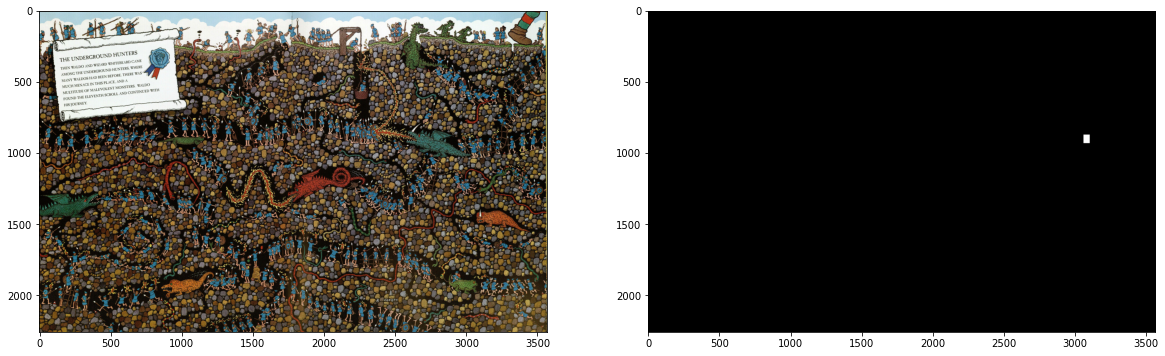

In [13]:
fname_rdm = random.choice(list(df_annotations["filename"].unique()))

fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
im = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_rdm))
np_im = np.array(im)
plt.imshow(np_im)

plt.subplot(1, 2, 2)
gt = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_rdm.split(".jpg")[0] + "_gt.png"))
np_gt = np.array(gt)
plt.imshow(np_gt)

plt.show()

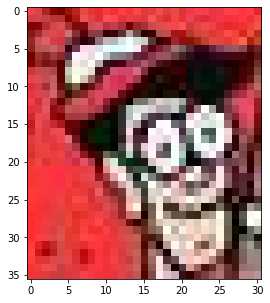

In [27]:
fname_rdm = random.choice(list(df_annotations["filename"].unique()))
im = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_rdm))
np_im = np.array(im)
gt = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_rdm.split(".jpg")[0] + "_gt.png")).convert("L")
np_gt = np.array(gt)
np_gt_labeled, n_waldo = label(np_gt, return_num=True)
fig = plt.figure(figsize=(5, 5))
for i_waldo in range(n_waldo):
    gt_cur = (np_gt_labeled == i_waldo+1).astype(int)
    coords = find_bounding_box_coords(gt_cur)
    plt.subplot(1, n_waldo, i_waldo+1)
    plt.imshow(np_im[coords[0]:coords[1], coords[2]:coords[3]])
plt.show()

In [28]:
print("Splitting dataset between Training / Validation / Testing...")
df_fname = df_annotations.drop_duplicates("filename")["filename"]
df_fname_train, df_fname_validate = \
    np.split(df_fname.sample(frac=1, random_state=int_seed_split), [int(ratio_train_dataset*len(df_fname))])
df_annotations["subset"] = "training"
df_annotations.loc[df_annotations["filename"].isin(df_fname_validate), "subset"] = "validation"

print(df_annotations.head())

Splitting dataset between Training / Validation / Testing...
  filename  width  height  class  xmin  ymin  xmax  ymax      subset
0  001.jpg   2048    1251  waldo   706   513   743   562    training
1  002.jpg   1286     946  waldo    82   521   107   554    training
2  003.jpg   2048    1346  waldo  1390   463  1422   500    training
3  004.jpg   2048    1272  waldo  1484   279  1507   306  validation
4  005.jpg   2100    1760  waldo   882   594   913   634    training


In [29]:
width_largest = df_annotations["width"].max()
height_ = df_annotations[df_annotations["width"] == width_largest]["height"].tolist()[0]
size_img = (width_largest, height_)

In [30]:
list_fname_train = df_annotations[df_annotations["subset"] == "training"]["filename"]
list_path_img_train = sorted([os.path.join(path_dataset_folder, path_image_folder, i) for i in list_fname_train])
list_path_gt_train = sorted([p.split(extension)[0] + "_gt.png" for p in list_path_img_train])
dataset_train = WaldoLoader(list_path_img=list_path_img_train,
                            list_path_gt=list_path_gt_train,
                            size_img=size_img,
                            size_patch=size_patch,
                            balance_positive=True,
                            sequence_transforms=sequence_data_augmentation)

Resizing all images to same dimensions: (3566, 2257) pixels^2 ...


In [31]:
list_fname_valid = df_annotations[df_annotations["subset"] == "validation"]["filename"]
list_path_img_valid = sorted([os.path.join(path_dataset_folder, path_image_folder, i) for i in list_fname_valid])
list_path_gt_valid = sorted([p.split(extension)[0] + "_gt.png" for p in list_path_img_valid])
dataset_valid = WaldoLoader(list_path_img=list_path_img_valid,
                            list_path_gt=list_path_gt_valid,
                            size_img=size_img,
                            size_patch=size_patch,
                            balance_positive=True,
                            sequence_transforms=None)

Resizing all images to same dimensions: (3566, 2257) pixels^2 ...


In [32]:
len(dataset_train), len(dataset_valid)

(4050, 1500)

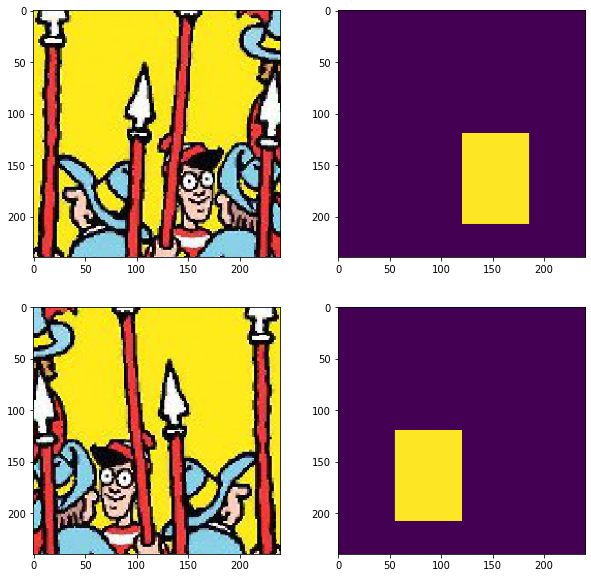

In [49]:
n_sample_positive = len(dataset_train.list_patch_positive_img)
idx_rdm_positive = np.random.randint(0, n_sample_positive-1)
sample = dataset_train.list_patch_positive_img[idx_rdm_positive]
sample_gt = dataset_train.list_patch_positive_gt[idx_rdm_positive]
flip = Sequence([RandomHorizontalFlip()], probs=1)
sample_flip, sample_gt_flip = flip(sample, sample_gt)

fig = plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(sample)
plt.subplot(2, 2, 2)
plt.imshow(sample_gt)
plt.subplot(2, 2, 3)
plt.imshow(sample_flip)
plt.subplot(2, 2, 4)
plt.imshow(sample_gt_flip)
plt.show()

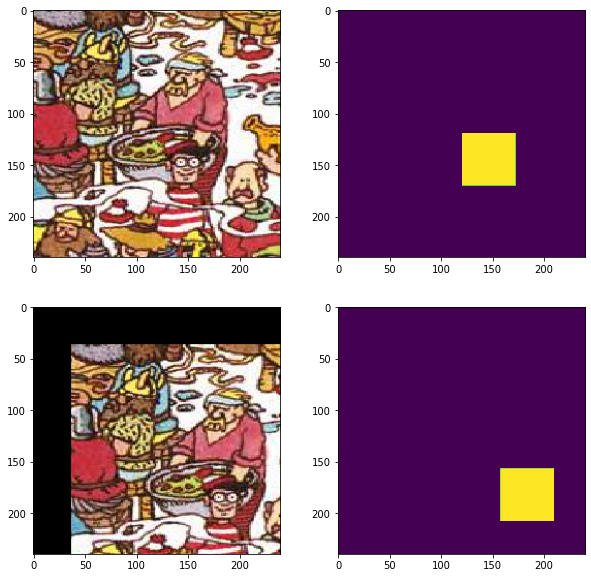

In [51]:
n_sample_positive = len(dataset_train.list_patch_positive_img)
idx_rdm_positive = np.random.randint(0, n_sample_positive-1)
sample = dataset_train.list_patch_positive_img[idx_rdm_positive]
sample_gt = dataset_train.list_patch_positive_gt[idx_rdm_positive]
translate = Sequence([RandomTranslate(0.2)], probs=1)
sample_translate, sample_gt_translate = translate(sample, sample_gt)

fig = plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(sample)
plt.subplot(2, 2, 2)
plt.imshow(sample_gt)
plt.subplot(2, 2, 3)
plt.imshow(sample_translate)
plt.subplot(2, 2, 4)
plt.imshow(sample_gt_translate)
plt.show()

In [33]:
loader_train = DataLoader(dataset_train, batch_size=size_batch, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=size_batch, shuffle=True)

tensor(-7.5058e-10) tensor(1.0000)
tensor([0., 1.], dtype=torch.float64) torch.Size([16, 1, 240, 240]) torch.Size([16, 3, 240, 240])


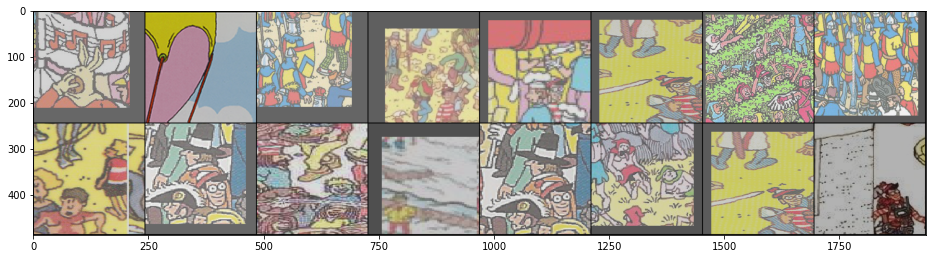

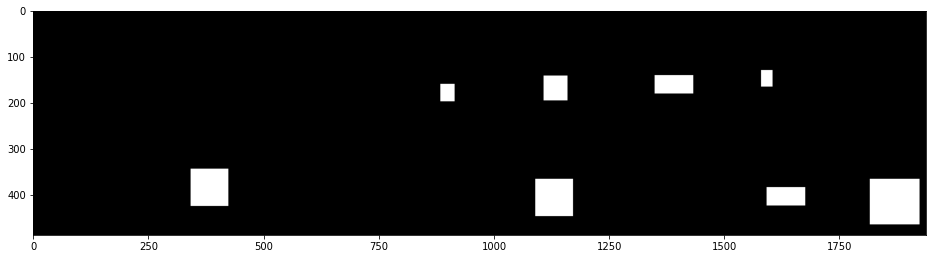

In [34]:
image_expl, label_expl = iter(loader_train).next()
print(image_expl.mean(), image_expl.std())
print(label_expl.unique(), label_expl.size(), image_expl.size())
plt.subplots(figsize=(16, 16))
imshow_tensor(torchvision.utils.make_grid(image_expl, normalize=True))
plt.subplots(figsize=(16, 16))
imshow_tensor(torchvision.utils.make_grid(label_expl))

In [36]:
model = Waldo_UNet(n_channels=3).cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.01)

In [37]:
model_trained = train_model(model,optimizer, loader_train, dataset_validation=loader_valid, n_epoch=n_epoch)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch#1 -- Train loss: -0.007 -- Validation loss: -0.003
Epoch#2 -- Train loss: -0.021 -- Validation loss: -0.026
Epoch#3 -- Train loss: -0.055 -- Validation loss: -0.015
Epoch#4 -- Train loss: -0.069 -- Validation loss: -0.065
Epoch#5 -- Train loss: -0.097 -- Validation loss: -0.083
Epoch#6 -- Train loss: -0.117 -- Validation loss: -0.043
Epoch#7 -- Train loss: -0.116 -- Validation loss: -0.105
Epoch#8 -- Train loss: -0.124 -- Validation loss: -0.135
Epoch#9 -- Train loss: -0.133 -- Validation loss: -0.097
Epoch#10 -- Train loss: -0.129 -- Validation loss: -0.013
Epoch#11 -- Train loss: -0.048 -- Validation loss: -0.004
Epoch#12 -- Train loss: -0.011 -- Validation loss: -0.024
Epoch#13 -- Train loss: -0.012 -- Validation loss: 0.001
Epoch#14 -- Train loss: 0.0 -- Validation loss: -0.004
Epoch#15 -- Train loss: -0.004 -- Validation loss: -0.003


In [42]:
torch.save(model_trained, fname_trained_model)

In [61]:
from loader import load_image
fname_rdm_test_image = random.choice([os.path.join(path_dataset_folder, "images_test", i) for i in os.listdir(os.path.join(path_dataset_folder, "images_test")) if i.endswith(".jpg")])
image_test = load_image(fname_rdm_test_image)

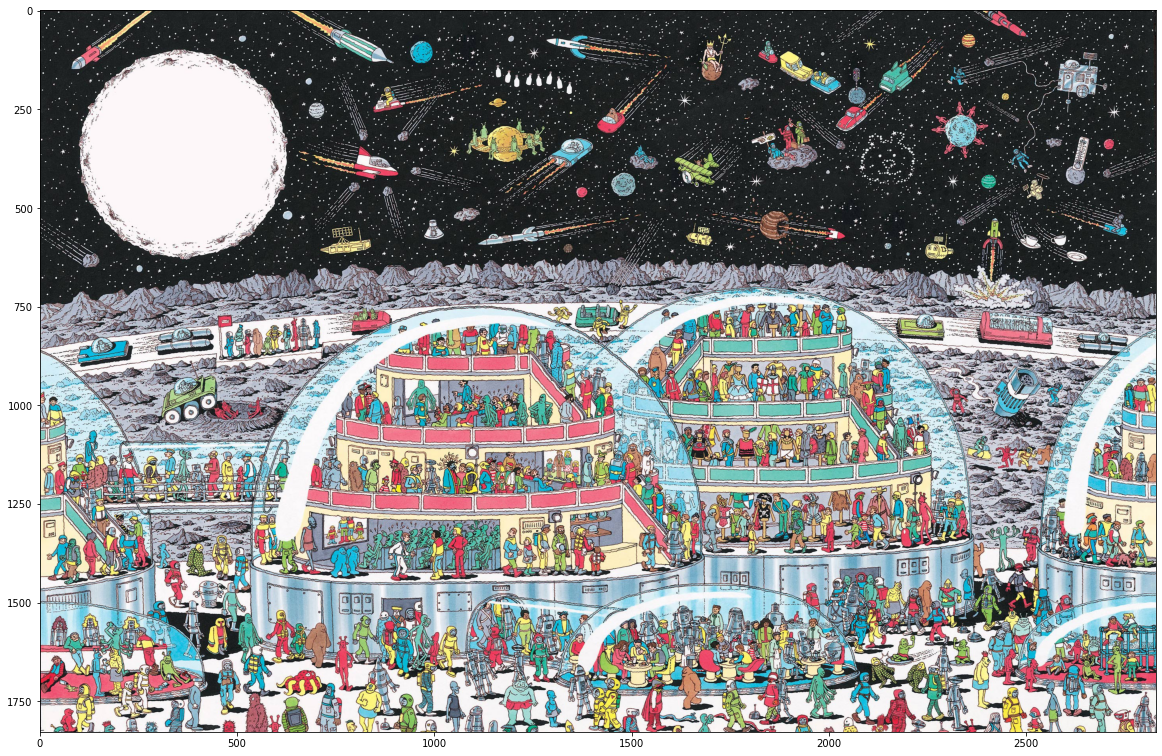

In [62]:
plt.figure(figsize=(20, 20))
plt.imshow(image_test)
plt.show()

In [69]:
from inference import patchify_test_image, reconstruct_image_from_patches #resize_image

image_test_resized = resize_image(image_test, size_patch=size_patch)
stack_patch = patchify_test_image(image_test_resized, size_patch)
print(stack_patch.shape)

ImportError: ignored

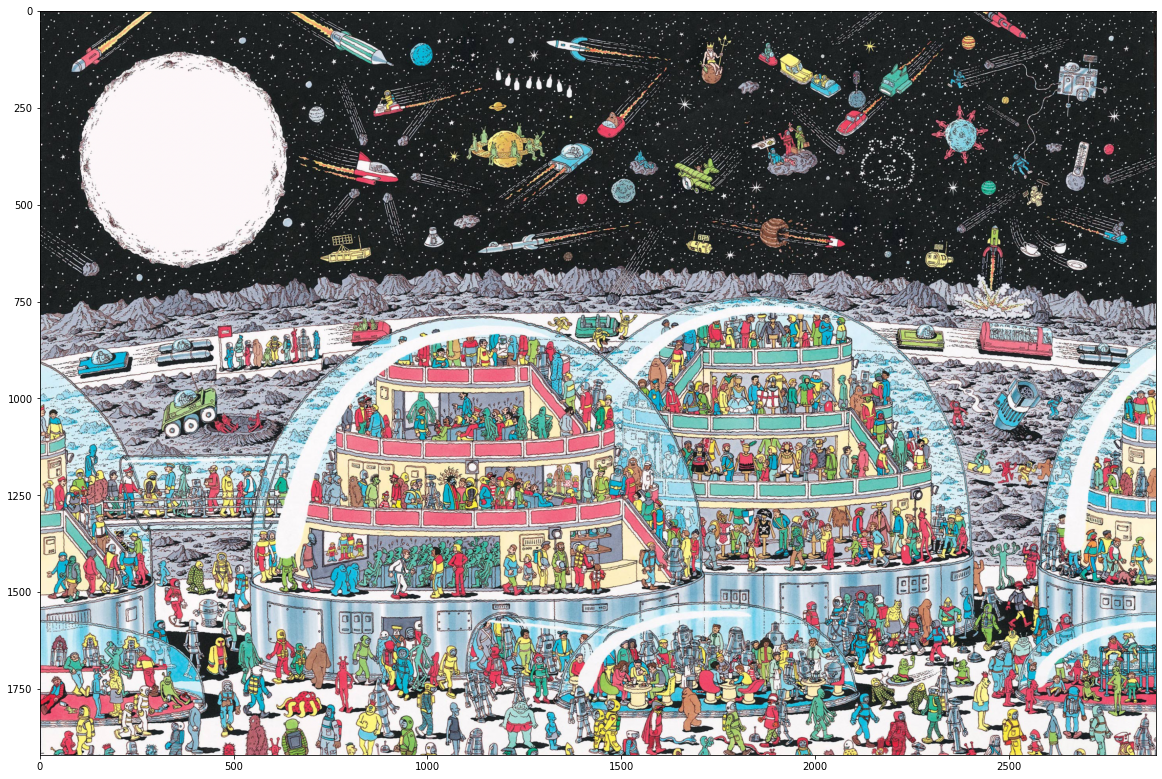

In [91]:
image_reconstructed = reconstruct_image_from_patches(image_test_resized, stack_patch, size_patch)
plt.figure(figsize=(20, 20))
plt.imshow(image_reconstructed)
plt.show()

In [95]:
stack_patch.shape

(96, 240, 240, 3)

In [96]:
print(stack_patch.shape)
stack_patch = np.swapaxes(np.swapaxes(stack_patch, 3, 1), 3, 2)
print(stack_patch.shape)


(96, 240, 240, 3)
(96, 3, 240, 240)
torch.Size([96, 3, 240, 240])


In [94]:
list(range(0, tensor_test.size()[0], size_batch))

[0, 16, 32, 48, 64, 80]

In [112]:
model_trained.eval()

list_pred = []
for i_pred, idx in enumerate(range(0, stack_patch.shape[0], size_batch)):
    tensor_test = torch.from_numpy(stack_patch[i_pred * size_batch : (i_pred + 1) * size_batch, :])
    tensor_test = tensor_test.cuda().float()
    pred = model_trained(tensor_test)
    pred = pred[:, 1:, :, :]
    list_pred.append(np.array(pred))
stack_pred = np.stack(list_pred)

RuntimeError: ignored

In [ ]:
image_prediction = reconstruct_image_from_patches(image_test_resized, stack_pred, size_patch)
plt.figure(figsize=(20, 20))
plt.imshow(image_reconstructed)
plt.show()